## Transformer-Based Image Captioning
The model architecture is composed of two elements:
- A pre-trained CNN (frozen weights) to create image embeddings
- Transformer layers to generate meaningful captions based on the image embedding

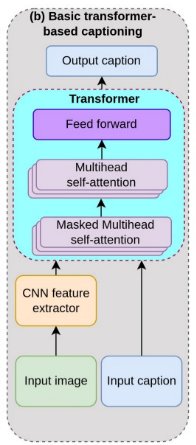

### Environment

In [1]:
!nvidia-smi

Sun Jun 23 18:24:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              27W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from matplotlib.pyplot import imshow
import os
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights, resnet101, ResNet101_Weights
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import pandas as pd

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('DEVICE:\n{}'.format(device))

DEVICE:
cuda


### Data Exploration (Flickr8k)

In [4]:
# Create a custom Dataset class to use with a DataLoader
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, captions_dir):
        self.image_dir = image_dir
        self.captions = self._load_captions(captions_dir)
        self.transform = transforms.Compose([
            transforms.Resize((448, 448)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    def _load_captions(self, captions_dir):
        captions = []
        with open(captions_dir, 'r') as f:
            next(f)
            for line in f:
                image_id = line.strip().split(',')[0]
                caption = ' '.join(line.strip().split(',')[1:])
                captions.append((image_id, caption))
        return captions
    
    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image_id, caption = self.captions[idx]
        image = Image.open(os.path.join(self.image_dir, image_id)).convert('RGB')
        image = self.transform(image)
        return image, caption, image_id

    def print_random_image(self):
        random_idx = np.random.randint(0, len(self))
        image, caption, _ = self.__getitem__(random_idx)
        print(caption)
        imshow(image.permute(1, 2, 0))

In [5]:
# Define the transform for showing the images
transform = transforms.Compose([transforms.Resize((448, 448)),
                                transforms.ToTensor()])

# Initialize the dataset
image_dir = '/kaggle/input/flickr8k/Images'
captions_dir = '/kaggle/input/flickr8k/captions.txt'
dataset = Flickr8kDataset(image_dir, captions_dir)

# Initialize the DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

An officer and dog are walking in front of a queue of people .


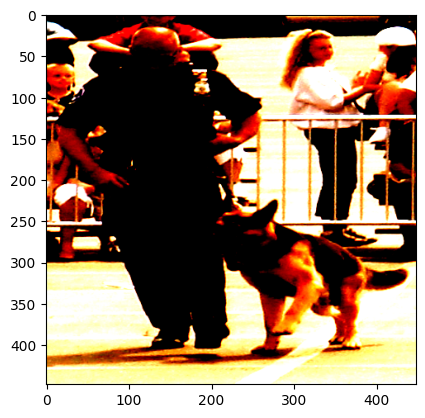

In [6]:
# Inspect some images and captions
dataset.print_random_image()

### Data Preparation

#### Image Embeddings
TODO: Add a fully connected layer to change the dimensionality of the embeddings, if needed (and make sure it is trainable)

In [7]:
# Create a custom Dataset class for image embeddings batch processing
class ImagesDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_ids = self._get_image_ids()
        self.transform = transforms.Compose([
            transforms.Resize((448, 448)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.image_ids)
    
    def _get_image_ids(self):
        image_ids = []
        for image_id in os.listdir(self.image_dir):
            image_ids.append(image_id)
        return image_ids

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image = Image.open(os.path.join(self.image_dir, image_id)).convert('RGB')
        image = self.transform(image)
        return image_id, image

In [8]:
# Load the ResNet model
model = resnet101(weights=ResNet101_Weights.DEFAULT)
model = model.to(device)
model = model.eval()

# Remove the last layer of the model
model = nn.Sequential(*list(model.children())[:-1])

# Initialize the dataset
image_dir = '/kaggle/input/flickr8k/Images'
images_dataset = ImagesDataset(image_dir)

# Initialize the DataLoader
images_dataloader = DataLoader(images_dataset, batch_size=128, shuffle=False)

# Extract image embeddings
image_embeddings = {}
for image_ids, images in tqdm(images_dataloader, desc="Embedding images"):
    images = images.to(device)
    with torch.no_grad():
        embeddings = model(images)
    for i in range(len(image_ids)):
        image_embeddings[image_ids[i]] = embeddings[i].cpu().numpy().flatten()

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:10<00:00, 16.5MB/s] 
Embedding images: 100%|██████████| 64/64 [03:17<00:00,  3.09s/it]


In [9]:
data = {
    'image_id': list(image_embeddings.keys()),
    'embedding': list(image_embeddings.values())
}

image_embeddings_df = pd.DataFrame(data)


In [19]:
image_embeddings_df

,image_id,embedding
0,3226254560_2f8ac147ea.jpg,"[0.01931041, 0.0, 0.13359992, 0.17243868, 0.00..."
1,214543992_ce6c0d9f9b.jpg,"[0.022359459, 0.0, 0.0, 0.0085133435, 0.132492..."
2,2366643786_9c9a830db8.jpg,"[0.0, 0.016261851, 0.10578496, 0.0016685337, 0..."
3,3368819708_0bfa0808f8.jpg,"[0.0447869, 0.015066331, 0.331603, 0.1117514, ..."
4,2190227737_6e0bde2623.jpg,"[0.024012847, 0.024770355, 0.0, 0.005484224, 0..."
...,...,...
8086,281419391_522557ce27.jpg,"[0.005318762, 0.0, 0.06725963, 0.0097440565, 0..."
8087,590445887_4d4fa43923.jpg,"[0.0, 0.0, 0.04276866, 0.002975753, 0.02960434..."
8088,502115726_927dd684d3.jpg,"[0.22177643, 0.0020494466, 0.06307989, 0.00164..."
8089,3025438110_40af7e6a80.jpg,"[0.03194757, 0.0009504652, 0.0196707, 0.108522..."


#### Caption Tokenization and Embedding
TODO: Pick another tokenizer and embedding model if needed, and make sure outputs are correct

In [10]:
# Create a custom Dataset class for the embedding of captions
class TokenizedCaptionsDataset(Dataset):
    def __init__(self, captions_dir):
        self.captions_dir = captions_dir
        self.captions = self._load_captions(captions_dir)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    def _load_captions(self, captions_dir):
        captions = []
        with open(captions_dir, 'r') as f:
            next(f)
            for line in f:
                image_id = line.strip().split(',')[0]
                caption = ' '.join(line.strip().split(',')[1:])
                captions.append((image_id, caption))
        return captions
    
    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image_id, caption = self.captions[idx]
        # Tokenize the caption
        encoding = self.tokenizer(caption, max_length=32, padding='max_length', truncation=True, return_tensors='pt')
        return image_id, encoding['input_ids'][0]

In [11]:
# Load the captions dataset
captions_dir = '/kaggle/input/flickr8k/captions.txt'
captions_dataset = TokenizedCaptionsDataset(captions_dir)

# Initialize the DataLoader
captions_dataloader = DataLoader(captions_dataset, batch_size=1028, shuffle=False)

# Load an embedding model for the tokenized captions
caption_embedding_model = BertModel.from_pretrained('bert-base-uncased').to(device)
caption_embedding_model = caption_embedding_model.eval()

# Extract caption embeddings
image_ids_lst = []
caption_embeddings_lst = []
for image_ids, input_ids in tqdm(captions_dataloader, desc="Embedding captions"):
    input_ids = input_ids.to(device)
    with torch.no_grad():
        outputs = caption_embedding_model(input_ids)
    for i in range(len(image_ids)):
        caption_embedding = outputs.last_hidden_state[i, 0].cpu().numpy()
        image_ids_lst.append(image_ids[i])
        caption_embeddings_lst.append(caption_embedding)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Embedding captions: 100%|██████████| 40/40 [01:00<00:00,  1.50s/it]


In [12]:
# Create a DataFrame to store the image and caption embeddings
caption_embeddings = pd.DataFrame(columns=['image_id', 'caption_embedding'])
caption_embeddings['image_id'] = image_ids_lst
caption_embeddings['caption_embedding'] = caption_embeddings_lst

In [13]:
caption_embeddings

,image_id,caption_embedding
0,1000268201_693b08cb0e.jpg,"[-0.33663532, -0.118171826, -0.034707323, 0.12..."
1,1000268201_693b08cb0e.jpg,"[-0.69958526, -0.15870059, -0.052873448, 0.361..."
2,1000268201_693b08cb0e.jpg,"[-0.71835685, -0.2747766, 0.04741285, 0.311954..."
3,1000268201_693b08cb0e.jpg,"[-0.6776553, -0.3278507, 0.043281734, 0.242428..."
4,1000268201_693b08cb0e.jpg,"[-0.55502754, -0.3955334, -0.09982508, 0.39174..."
...,...,...
40450,997722733_0cb5439472.jpg,"[-0.39646044, 0.053042833, 0.08159736, 0.08362..."
40451,997722733_0cb5439472.jpg,"[-0.48097208, 0.08663706, 0.11043812, 0.113462..."
40452,997722733_0cb5439472.jpg,"[-0.58589846, -0.08621835, -0.19471297, 0.2163..."
40453,997722733_0cb5439472.jpg,"[-0.7165839, -0.17432071, -0.13890158, 0.27873..."


#### Create Train and Test Datasets
TODO: Make sure that the captions that belong to the embeddings can still be found
TODO: Make sure the train test split is not based on the captions to avoid images being in both train and test sets

In [14]:
class EmbeddingsDataset(Dataset):
    def __init__(self, image_embeddings_df, caption_embeddings_df):
        self.image_embeddings_df = image_embeddings_df
        self.caption_embeddings_df = caption_embeddings_df

    def __len__(self):
        return len(self.caption_embeddings_df)

    def __getitem__(self, idx):
        row = self.caption_embeddings_df.iloc[idx]
        image_id = row['image_id']
        image_embedding = self.image_embeddings_df[self.image_embeddings_df['image_id'] == image_id]['embedding'].values[0]
        caption_embedding = row['caption_embedding']
        return image_embedding, caption_embedding, image_id


In [15]:
# Initialize the dataset
embeddings_dataset = EmbeddingsDataset(image_embeddings_df, caption_embeddings)

# Create train and test split
train_size = int(0.8 * len(embeddings_dataset))
test_size = len(embeddings_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(embeddings_dataset, [train_size, test_size])

# Initialize the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
for i, (image_embeddings, caption_embeddings, image_ids) in enumerate(train_dataloader):
        print(f"Batch {i + 1}")
#         print(f"Image Embeddings: {image_embeddings}")
        print(f"Image Embeddings Shape: {image_embeddings.shape}")
#         print(f"Caption Embeddings: {caption_embeddings}")
        print(f"Caption Embeddings Shape: {caption_embeddings.shape}")
#         print(f"Image IDs: {image_ids}")
        break  # Only inspect the first batch for simplicity
len(train_dataloader)

Batch 1
Image Embeddings Shape: torch.Size([32, 2048])
Caption Embeddings Shape: torch.Size([32, 768])


1012

### Implement Model

In [43]:
import torch
import torch.nn as nn

class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len_t,
        device,
    ):
        super(Transformer, self).__init__()
        self.device = device
        
        # Positional encoding
        self.src_position_embedding = nn.Parameter(torch.zeros(1, 1, embedding_size))  # Single position for image embedding
        self.trg_position_embedding = nn.Parameter(torch.zeros(1, max_len_t, embedding_size))
 
        self.image_projection = nn.Linear(2048, embedding_size)  # Assuming image embedding size is 2048
        self.caption_projection = nn.Linear(768, embedding_size)  # Assuming caption embedding size is 768
        
        # Transformer
        self.transformer = nn.Transformer(
            d_model=embedding_size,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=forward_expansion,
            dropout=dropout,
            batch_first=True
        )
        
        self.fc_out = nn.Linear(embedding_size, embedding_size)
        self.dropout = nn.Dropout(dropout)

    def make_src_mask(self, src):
        src_mask = torch.zeros(src.shape[0], src.shape[1], dtype=torch.bool).to(self.device)
        return src_mask
    def forward(self, src, trg):
        N, src_seq_length = src.shape[0], 1  # Single image embedding
        trg_seq_length = trg.shape[1]

        src_positions = torch.zeros((N, src_seq_length), dtype=torch.long).to(self.device)
        trg_positions = torch.arange(0, trg_seq_length).unsqueeze(0).expand(N, trg_seq_length).to(self.device)
        
#         print(f"src shape after projection: {src.shape}")
#         print(f"trg shape after projection: {trg.shape}")
#         print(f"src_position_embedding shape: {self.src_position_embedding.shape}")
#         print(f"trg_position_embedding shape: {self.trg_position_embedding[:, :trg_seq_length, :].shape}")
        src = self.image_projection(src)
        trg = self.caption_projection(trg)
        
        print(f"src shape after projection: {src.shape}")
        print(f"trg shape after projection: {trg.shape}")
        print(f"src_position_embedding shape: {self.src_position_embedding.shape}")
        print(f"trg_position_embedding shape: {self.trg_position_embedding[:, :trg_seq_length, :].shape}")

        embed_src = self.dropout(src + self.src_position_embedding)
        embed_trg = self.dropout(trg + self.trg_position_embedding[:, :trg_seq_length, :])

        print(f"embed_src shape: {embed_src.shape}")
        print(f"embed_trg shape: {embed_trg.shape}")

        src_padding_mask = self.make_src_mask(embed_src).squeeze()  # Adjust the shape to (N, src_seq_length)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(self.device)        
        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out


### Training Loop

In [44]:
import torch.optim as optim

# Initialize the model
embedding_size = 512
num_heads = 8
num_encoder_layers = 6
num_decoder_layers = 6
forward_expansion = 2048
dropout = 0.1
max_len_t = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(
    embedding_size,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len_t,
    device
).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for image_embeddings, caption_embeddings, _ in train_dataloader:
        # Move data to device
        image_embeddings, caption_embeddings = image_embeddings.to(device), caption_embeddings.to(device)

        # Prepare the target and source sequences
#         src = image_embeddings
#         tgt_input = caption_embeddings[:, :-1]
#         tgt_output = caption_embeddings[:, 1:]
        print(f"Batch {i + 1}:")
        print(f"image_embeddings shape: {image_embeddings.shape}")
        print(f"caption_embeddings shape: {caption_embeddings.shape}")
        
        outputs = model(image_embeddings, caption_embeddings)

        # Forward pass
#         outputs = model(src, tgt_input)
        
        # Compute loss
        outputs = outputs.view(-1, outputs.size(2))
        tgt_output = tgt_output.view(-1)
        loss = criterion(outputs, tgt_output)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the model
torch.save(model.state_dict(), 'transformer_captioning_model.pth')


Batch 1:
image_embeddings shape: torch.Size([32, 2048])
caption_embeddings shape: torch.Size([32, 768])
src shape after projection: torch.Size([32, 512])
trg shape after projection: torch.Size([32, 512])
src_position_embedding shape: torch.Size([1, 1, 512])
trg_position_embedding shape: torch.Size([1, 32, 512])
embed_src shape: torch.Size([1, 32, 512])
embed_trg shape: torch.Size([1, 32, 512])


AssertionError: For batched (3-D) `query`, expected `key_padding_mask` to be `None` or 2-D but found 1-D tensor instead

### Model Evaluation